# Neural Network 101

The effectiveness of a deep learning model depends on several factors. These include the choice of architecture, the number of hidden layers, the number of neurons in each layer, the optimizer and activation functions used, and the number of training epochs.

While research literature and factors such as dataset type can help guide the selection of an appropriate model architecture, choosing other factors like the number of layers or training epochs typically requires a trial and error process.

In this tutorial, you will get hands-on experience with this process. For simplicity, we will restrict the model architecture to a neural network (NN). However, you will have the opportunity to experiment with different activation functions, optimizers, network configurations, and training epochs.

Below, you will find simplified definitions of important terminology. We have intentionally kept the explanations non-technical, as theoretical exploration is beyond the scope of this project. However, if you are interested in learning more or gaining deeper insight, please refer to this link `https://www.geeksforgeeks.org/machine-learning/neural-networks-a-beginners-guide/` for further exploration.


1) __NN__: A neural network (NN) is a deep learning model architecture inspired by the structure and functioning of the human brain. It consists of artificial neurons, which resemble biological brain cells. These neurons are organized into layers and are interconnected, mimicking the way brain cells are connected in the nervous system.

3) __Hidden Layer__: A neural network (NN) consists of three or more layers of neurons. The first and last layers are called the input and output layers, respectively. The layers between them are known as hidden layers (Layers with neurons highlighted in red).

![NN model architecture](../../Images/NN.png)

3) __Activation Function__: One of the key reasons for the widespread adoption of neural networks is their ability to capture non-linear patterns in data. This capability is made possible through the use of activation functions, which introduce non-linearity into the model.

4) __Optimizer__: Optimizer algorithms help a model improve its performance by reducing the error between its predicted and target values.

5) __Epochs__: An epoch is one complete pass through the entire training dataset by the model during training.

6) __Mean Squared Error__: The average of the squared differences between predicted and actual values. This metric penalizes larger errors more heavily, making it sensitive to outliers. A lower MSE indicates fewer large errors and smaller overall prediction errors.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class DatasetClass(Dataset):
    def __init__(self, num_samples=300):
        noise_std=0.8
        seed=42
        np.random.seed(seed)
        self.x = np.sort(np.random.uniform(-3.5, 3.5, num_samples)).astype(np.float32)

        y = (
            np.sin(7 * self.x ** 3)
            + np.log(np.abs(self.x) + 1) * np.cos(3 * self.x ** 2)
            + np.tanh(self.x ** 4)
        ) * np.exp(-self.x ** 2 / 2) + 0.3 * self.x ** 5

        y += np.random.normal(0, noise_std, size=self.x.shape)

        self.x = torch.tensor(self.x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class ModelClass(nn.Module):
    def __init__(self, model_block: nn.Sequential, activation: str = "relu"):
        super().__init__()
        self.model = model_block

    def forward(self, x):
        return self.model(x)

class TrainClass:
    def __init__(self, model, dataset, optimizer_name="adam", lr=0.01, epochs=30, batch_size=32, test_size=0.2):
        self.model = model
        self.epochs = epochs
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = self._get_optimizer(optimizer_name, model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5)
        self.train_loader, self.test_loader = self._split_dataset(dataset, test_size, batch_size)
        self.train_losses = []

    def _get_optimizer(self, name, parameters, lr):
        name = name.lower()
        if name == "adam":
            return torch.optim.Adam(parameters, lr=lr)
        elif name == "sgd":
            return torch.optim.SGD(parameters, lr=lr)
        elif name == "adamw":
            return torch.optim.AdamW(parameters, lr=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {name}")

    def _split_dataset(self, dataset, test_size, batch_size):
        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=42)
        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)
        return (
            DataLoader(train_set, batch_size=batch_size, shuffle=True),
            DataLoader(test_set, batch_size=batch_size, shuffle=False)
        )

    def train(self):
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            total_loss = 0
            for xb, yb in self.train_loader:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            self.scheduler.step()
            avg_loss = total_loss / len(self.train_loader)
            self.train_losses.append(avg_loss)

            if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch} | Train Loss: {avg_loss:.6f}")

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        preds, targets = [], []

        with torch.no_grad():
            for xb, yb in self.test_loader:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                total_loss += loss.item()
                preds.append(pred)
                targets.append(yb)

        final_mse = total_loss / len(self.test_loader)
        print(f"\nFinal Test MSE: {final_mse:.6f}")
        return torch.cat(preds), torch.cat(targets)

class PlotClass:
    @staticmethod
    def loss(train_losses):
        plt.figure(figsize=(8, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title("Training Loss")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def predictions(model, dataset):
        model.eval()
        with torch.no_grad():
            x_all = dataset.x
            y_true = dataset.y
            y_pred = model(x_all)

        plt.figure(figsize=(10, 4))
        plt.scatter(x_all.numpy(), y_true.numpy(), s=10, label="True", alpha=0.5)
        plt.plot(x_all.numpy(), y_pred.numpy(), color="red", label="Predicted", linewidth=2)
        plt.title("Regression Fit with Noise")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

## Excersice 1:

In this exercise, there are 12 possible combinations of activation functions (relu, tanh, leaky_relu, gelu) and optimizers (adam, sgd, adamw). Randomly select five of these combinations. For each one, train the model for 30 epochs and record both the training loss and final test MSE. Identify which combination results in the lowest final test MSE and training loss.

Epoch 1 | Train Loss: 1973.513184
Epoch 5 | Train Loss: 1387.915390
Epoch 10 | Train Loss: 1194.740356
Epoch 15 | Train Loss: 1605.185425
Epoch 20 | Train Loss: 1292.841202
Epoch 25 | Train Loss: 1371.446228
Epoch 30 | Train Loss: 1598.088982

Final Test MSE: 1534.830383


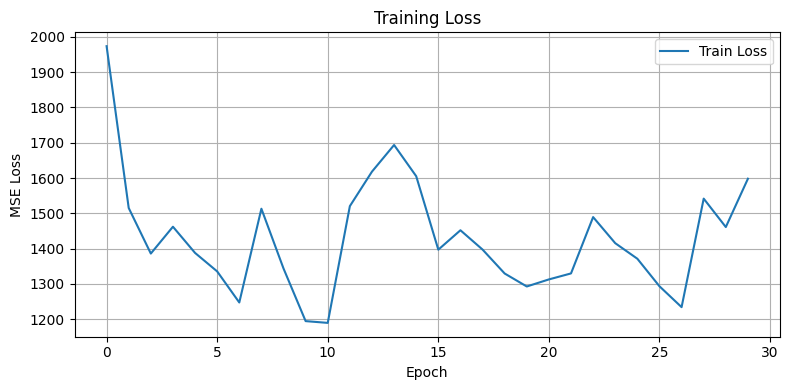

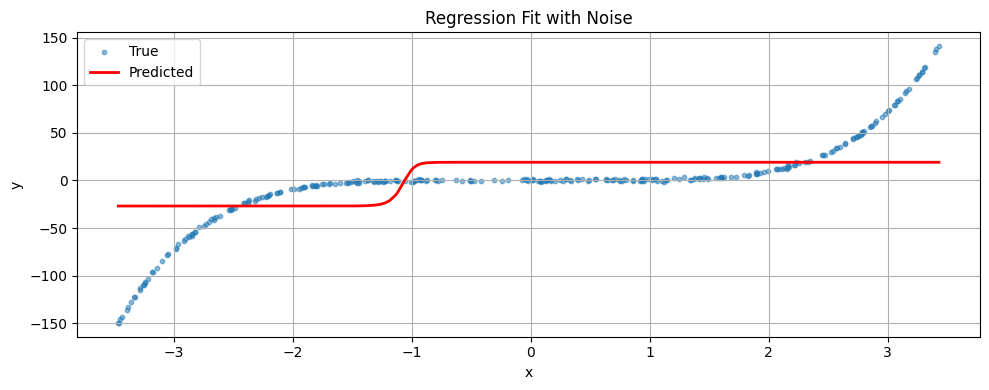

In [2]:
if __name__ == "__main__":

    # TODO: Select five of these combinations activationa and 
    # activation = "relu"     # Options: relu, tanh, leaky_relu, gelu
    # optimizer = "adam"      # Options: adam, sgd, adamw
    activation = "tanh"
    optimizer = "sgd"

    epochs = 30

    act_map = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leaky_relu": nn.LeakyReLU(),
            "gelu": nn.GELU()
        }
    act_ftn = act_map[activation.lower()] 
    
    model_block = nn.Sequential(
        nn.Linear(1, 16),
        act_ftn,
        nn.Linear(16, 4),
        act_ftn,
        nn.Linear(4, 1)
    )
    

    dataset = DatasetClass()
    model = ModelClass(model_block=model_block, activation=activation)
    trainer = TrainClass(model, dataset, optimizer_name=optimizer, epochs=epochs)

    trainer.train()
    trainer.evaluate()
    PlotClass.loss(trainer.train_losses)
    PlotClass.predictions(model, dataset)

Training with Activation: relu, Optimizer: adam
Epoch 1 | Train Loss: 2164.369110
Epoch 5 | Train Loss: 1843.841919
Epoch 10 | Train Loss: 888.169987
Epoch 15 | Train Loss: 745.116325
Epoch 20 | Train Loss: 704.140594
Epoch 25 | Train Loss: 630.996941
Epoch 30 | Train Loss: 562.769539

Final Test MSE: 645.585724

Final Test MSE: 645.585724
Training with Activation: relu, Optimizer: sgd
Epoch 1 | Train Loss: 2096.260490
Epoch 5 | Train Loss: 2452.829376
Epoch 10 | Train Loss: 2330.866920
Epoch 15 | Train Loss: 2215.086563
Epoch 20 | Train Loss: 2232.572144
Epoch 25 | Train Loss: 2104.927517
Epoch 30 | Train Loss: 2184.644806

Final Test MSE: 2289.180542

Final Test MSE: 2289.180542
Training with Activation: relu, Optimizer: adamw
Epoch 1 | Train Loss: 2242.345390
Epoch 5 | Train Loss: 1889.046844
Epoch 10 | Train Loss: 1026.066101
Epoch 15 | Train Loss: 818.893372
Epoch 20 | Train Loss: 784.879395
Epoch 25 | Train Loss: 731.742779
Epoch 30 | Train Loss: 651.291840

Final Test MSE: 775.4

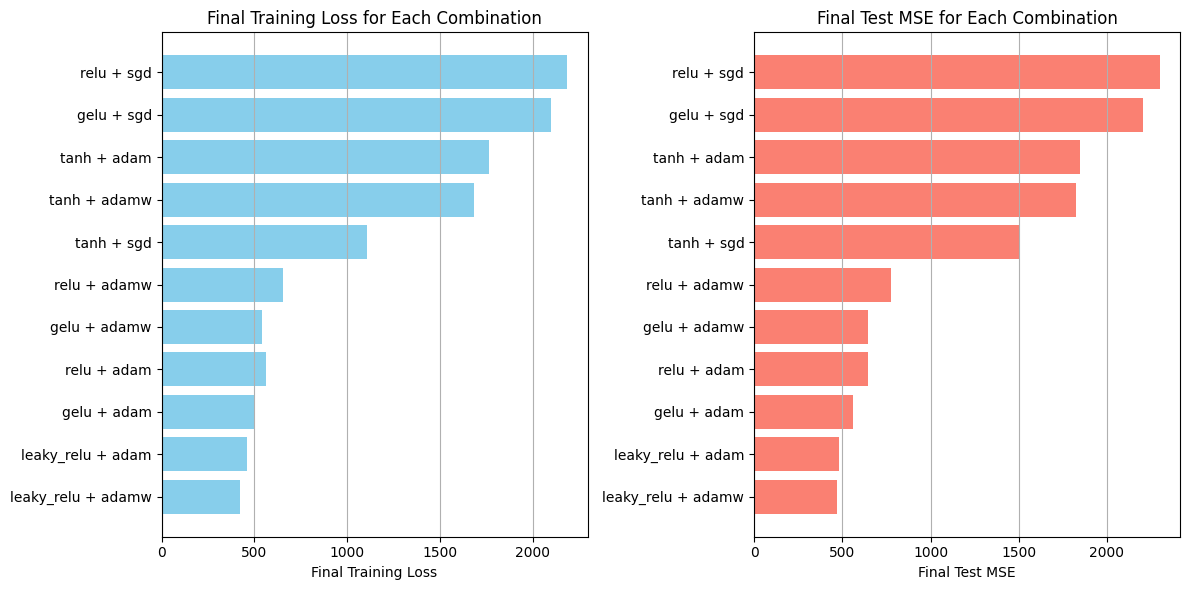

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define DatasetClass, ModelClass, TrainClass, and PlotClass (reuse from your notebook)

# Define the combinations of activation functions and optimizers
activations = ["relu", "tanh", "leaky_relu", "gelu"]
optimizers = ["adam", "sgd", "adamw"]

# Store results
results = []

# Iterate through all combinations
for activation in activations:
    for optimizer in optimizers:
        print(f"Training with Activation: {activation}, Optimizer: {optimizer}")
        
        # Define activation function
        act_map = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leaky_relu": nn.LeakyReLU(),
            "gelu": nn.GELU()
        }
        act_ftn = act_map[activation.lower()]
        
        # Define model architecture
        model_block = nn.Sequential(
            nn.Linear(1, 16),
            act_ftn,
            nn.Linear(16, 4),
            act_ftn,
            nn.Linear(4, 1)
        )
        
        # Initialize dataset, model, and trainer
        dataset = DatasetClass()
        model = ModelClass(model_block=model_block, activation=activation)
        trainer = TrainClass(model, dataset, optimizer_name=optimizer, epochs=30)
        
        # Train the model
        trainer.train()
        
        # Evaluate the model and get final test MSE
        _, _ = trainer.evaluate()
        preds, targets = trainer.evaluate()
        final_test_mse = torch.nn.functional.mse_loss(preds, targets).item()  # Convert tensor to float
        
        # Record the final training loss and test MSE
        final_train_loss = trainer.train_losses[-1]
        results.append({
            "Activation": activation,
            "Optimizer": optimizer,
            "Final Training Loss": final_train_loss,
            "Final Test MSE": final_test_mse
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by the lowest test MSE
results_df = results_df.sort_values(by="Final Test MSE")

# Print the results in a table
print("\nResults:")
print(results_df)

# Highlight the best combination
best_combination = results_df.iloc[0]
print(f"\nBest Combination: Activation = {best_combination['Activation']}, Optimizer = {best_combination['Optimizer']}")
print(f"Lowest Test MSE: {best_combination['Final Test MSE']}")

# Plot Final Training Loss and Test MSE for all combinations
plt.figure(figsize=(12, 6))

# Plot Final Training Loss
plt.subplot(1, 2, 1)
plt.barh(results_df["Activation"] + " + " + results_df["Optimizer"], results_df["Final Training Loss"], color="skyblue")
plt.xlabel("Final Training Loss")
plt.title("Final Training Loss for Each Combination")
plt.grid(axis="x")

# Plot Final Test MSE
plt.subplot(1, 2, 2)
plt.barh(results_df["Activation"] + " + " + results_df["Optimizer"], results_df["Final Test MSE"], color="salmon")
plt.xlabel("Final Test MSE")
plt.title("Final Test MSE for Each Combination")
plt.grid(axis="x")

plt.tight_layout()
plt.show()

## Excersice 2:
Currently, the model architecture is defined as follows: the input layer is nn.Linear(1, 16), the hidden layer is nn.Linear(16, 4), and the output layer is nn.Linear(4, 1).

```
model_block = nn.Sequential(
    nn.Linear(1, 16),
    act_ftn,
    nn.Linear(16, 4),
    act_ftn,
    nn.Linear(4, 1)
)
```

If you want to add an additional hidden layer, you can modify the architecture like this:
```
model_block = nn.Sequential(
    nn.Linear(1, 16),
    act_ftn,
    nn.Linear(16, 8), 
    act_ftn,
    nn.Linear(8, 4),
    act_ftn,
    nn.Linear(4, 1)
)
```

Notice that the output dimension of one layer must match the input dimension of the next layer. For example, the first hidden layer outputs 16 values, so the next layer must accept 16 as its input dimension. If these dimensions do not align, you will encounter a RuntimeError.


In this exercise, add two additional hidden layers to the model architecture shown below. Then, use the best combination of optimizer and activation function identified in Exercise 1, and train the updated model on 20 epochs.

```
model_block = nn.Sequential(
    nn.Linear(1, 128),
    act_ftn,
    nn.Linear(128, 16),
    act_ftn,
    nn.Linear(16, 1)
)
```

## Excersice 3:
I was able to achieve a final test MSE of 3.446659 in 30 epochs. Can you build a better model using any combination of optimizer and activation function and beat my result within the same epoch limit?

In [ ]:
if __name__ == "__main__":

    
    activation = "relu"     # Options: relu, tanh, leaky_relu, gelu
    optimizer = "adam"      # Options: adam, sgd, adamw
    epochs = 30

    act_map = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leaky_relu": nn.LeakyReLU(),
            "gelu": nn.GELU()
        }
    act_ftn = act_map[activation.lower()] 
    
    model_block = nn.Sequential(
        nn.Linear(1, 16),
        act_ftn,
        nn.Linear(16, 4),
        act_ftn,
        nn.Linear(4, 1)
    )
    

    dataset = DatasetClass()
    model = ModelClass(model_block=model_block, activation=activation)
    trainer = TrainClass(model, dataset, optimizer_name=optimizer, epochs=epochs)

    trainer.train()
    trainer.evaluate()
    PlotClass.loss(trainer.train_losses)
    PlotClass.predictions(model, dataset)

## Next Step: 
`/BuildingsBenchTutorial/Tutorials/Final-Project-Modules/`